<a href="https://colab.research.google.com/github/simon-mellergaard/datasimon/blob/main/Kaggle%20competitions/introverts-extroverts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting up for Colab

In [1]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import matplotlib as plt
import seaborn as sns
import warnings
import pandas as pd
import os

warnings.filterwarnings('ignore')

In [2]:
# Slect platform (colab or kaggle)
PlATFORM_IS_KAGGLE = True

if PlATFORM_IS_KAGGLE:
    INPUT_PATH = '/kaggle/input/playground-series-s5e7'
else:
    import kagglehub
    from google.colab import userdata
    !mkdir ~/.kaggle
    !echo -n '{"username":"simonmellergaard","key":"' > ~/.kaggle/kaggle.json
    !echo -n {userdata.get('Kaggle')} >> ~/.kaggle/kaggle.json
    !echo -n '"}' >> ~/.kaggle/kaggle.json
    !chmod 600 ~/.kaggle/kaggle.json
    playground_series_s5e7_path = kagglehub.competition_download('playground-series-s5e7')
    print('Data source import complete and located at: ' + playground_series_s5e7_path)
    INPUT_PATH = '/root/.cache/kagglehub/competitions/playground-series-s5e7'
CURRENT_DIR = os.getcwd()

# Making advanced predictions of extrovetrs and introverts

The code is showing the way.

In [3]:
data_raw = pd.read_csv(f'{INPUT_PATH}/train.csv', index_col='id')

In [4]:
data_raw.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
id,,,,,,,,
0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


The description of the variables are as follows:
* Time_spent_Alone: Hours spent alone daily (0–11).
* Stage_fear: Presence of stage fright (Yes/No).
* Social_event_attendance: Frequency of social events (0–10).
* Going_outside: Frequency of going outside (0–7).
* Drained_after_socializing: Feeling drained after socializing (Yes/No).
* Friends_circle_size: Number of close friends (0–15).
* Post_frequency: Social media post frequency (0–10).
* Personality: Target variable (Extrovert/Introvert).

There are two categorical variables and 6 numeric varialbe. The target variable is binary, so it is a binary classification problem.

In [5]:
data_raw.describe()

,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,17334.000000,17344.000000,17058.000000,17470.000000,17260.000000
mean,3.137764,5.265106,4.044319,7.996737,4.982097
std,3.003786,2.753359,2.062580,4.223484,2.879139
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,3.000000,3.000000,5.000000,3.000000
50%,2.000000,5.000000,4.000000,8.000000,5.000000
75%,4.000000,8.000000,6.000000,12.000000,7.000000
max,11.000000,10.000000,7.000000,15.000000,10.000000


In [6]:
data_raw.dtypes

Time_spent_Alone             float64
Stage_fear                    object
Social_event_attendance      float64
Going_outside                float64
Drained_after_socializing     object
Friends_circle_size          float64
Post_frequency               float64
Personality                   object
dtype: object

array([[<Axes: title={'center': 'Time_spent_Alone'}>,
        <Axes: title={'center': 'Social_event_attendance'}>],
       [<Axes: title={'center': 'Going_outside'}>,
        <Axes: title={'center': 'Friends_circle_size'}>],
       [<Axes: title={'center': 'Post_frequency'}>, <Axes: >]],
      dtype=object)

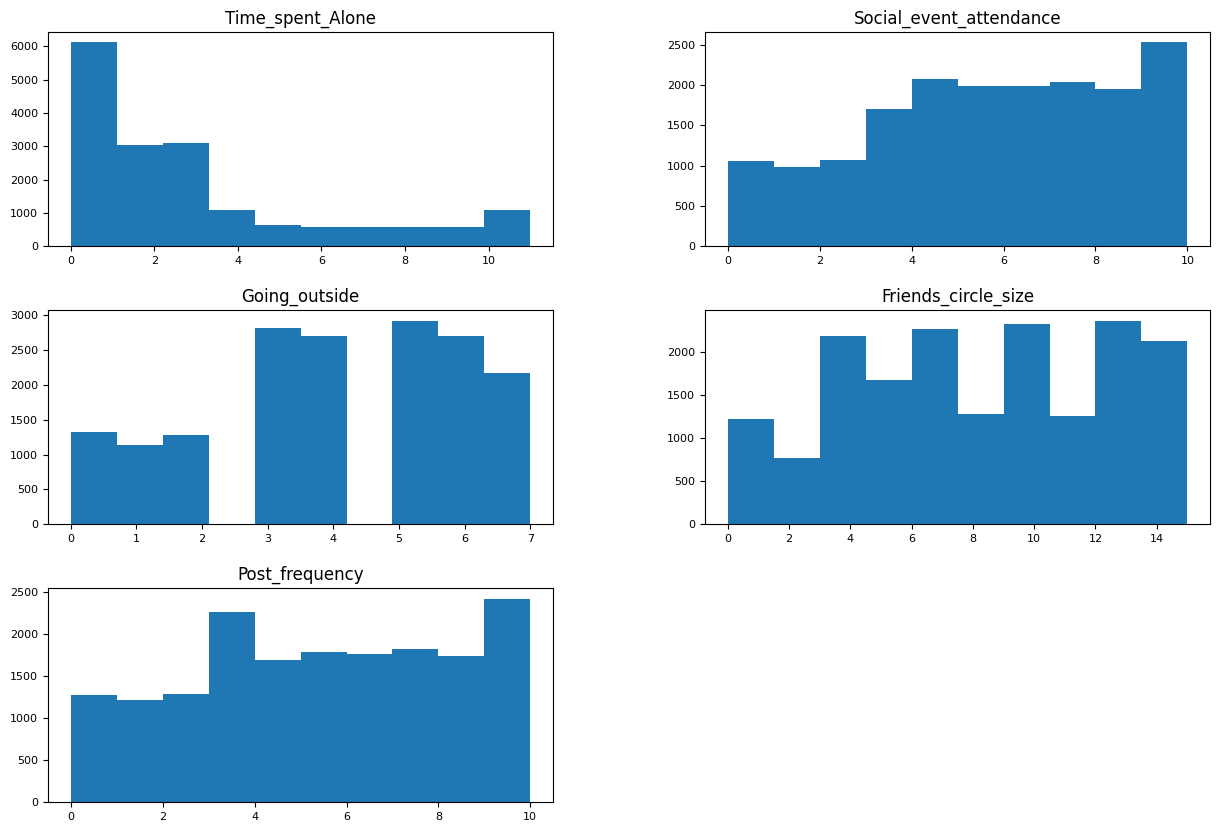

In [7]:
data_raw.hist(figsize=(15, 10), xlabelsize=8, ylabelsize=8, grid=False)

The data looks to be pretty uniformly distributed, however time spend alone tend to be right skewed.

In [8]:
data = data_raw.copy()
data['Introvert'] = data['Personality'].map({"Extrovert": 0, "Introvert": 1})
data['Stage_fear'] = data['Stage_fear'].map({"No": 0, "Yes": 1})
data['Drained_after_socializing'] = data['Drained_after_socializing'].map({"No": 0, "Yes": 1})
data = data.drop(columns=['Personality'])

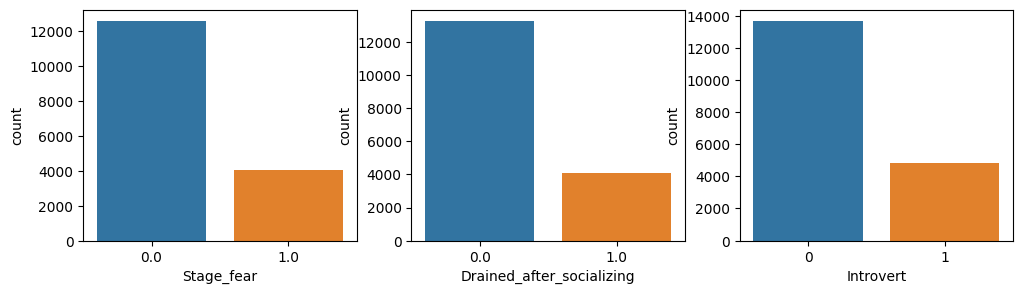

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 3))
plt.title("Categoraical variables")
plt.axis("off")
plot_count = 0  # Initialize a counter for displayed images
categorical_variables = ['Stage_fear', 'Drained_after_socializing', 'Introvert']

for var in categorical_variables:
    ax = plt.subplot(1, 3, plot_count + 1)  # Adjust subplot position
    sns.countplot(data, x = var)
    plot_count += 1  # Increment the counter
plt.show()

All distributions look moderately skewed.

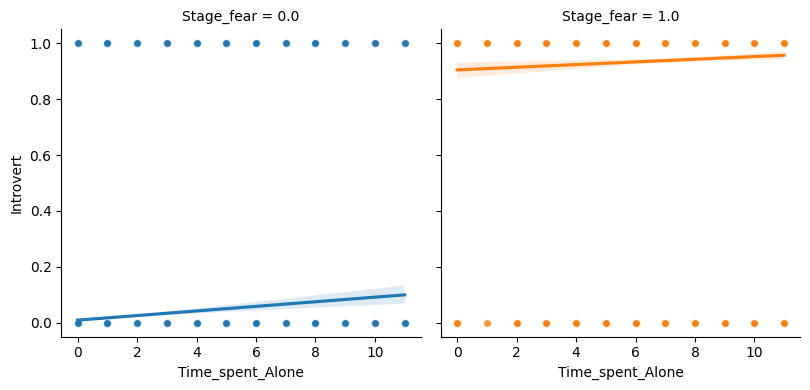

In [10]:
sns.lmplot(
    x='Time_spent_Alone', y="Introvert", hue="Stage_fear", col="Stage_fear",
    data=data, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4,
);

The missing data in the dataframe should be considered.

In [11]:
data.isnull().sum()

Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Introvert                       0
dtype: int64

There seems to be missing data in all columns except for the target value. An imputation strategy should be used.

In [12]:
my_imputer_cat = SimpleImputer(strategy='most_frequent')
data[['Stage_fear', 'Drained_after_socializing']] = my_imputer_cat.fit_transform(data[['Stage_fear', 'Drained_after_socializing']])
my_imputer_num = SimpleImputer(strategy='median')
data_clean = pd.DataFrame(my_imputer_num.fit_transform(data))
data_clean.columns = data.columns

# Preparing data

The data is split into a training and testing set

In [13]:
# Making X and y variables
X = data_clean.copy()
y = X.pop('Introvert')
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)

## Going for an XGboost

The following code will fit a classic XGboost with some different parameters

In [14]:
from xgboost import XGBClassifier
model = XGBClassifier(n_estimators=200, learning_rate=0.05)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [15]:
preds = model.predict(X_val)
acc = accuracy_score(y_val, preds)
print("Accuracy: " , acc*100, " %", sep="")
print(confusion_matrix(y_val, preds))

Accuracy: 96.84733318937595 %
[[3362   62]
 [  84 1123]]


This is a good accuracy, but can it get better?

## XGB with hyperparameter tuning

In [16]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize the XGBoost classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters: ", grid_search.best_params_)
print("Best accuracy: ", grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

Best parameters:  {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.6}
Best accuracy:  0.9687612466709853


In [17]:
preds = best_model.predict(X_val)
acc = accuracy_score(y_val, preds)
print("Accuracy: " , acc*100, " %", sep="")
print(confusion_matrix(y_val, preds))

Accuracy: 96.93370762254374 %
[[3363   61]
 [  81 1126]]


Hyperparameter tuning slightly improved the model.

# Making predictions on the test set

The best model is being used to predict on the test set. However the test set first needs to be loaded and preprocessed just like the training set.

In [18]:
# The below code should be converted to a function for future use to avoid code cuplication
data_test = pd.read_csv(f'{INPUT_PATH}/test.csv', index_col='id')

my_encoder = OrdinalEncoder() # Your code here
data_test[['Stage_fear', 'Drained_after_socializing']] = my_encoder.fit_transform(data_test[['Stage_fear', 'Drained_after_socializing']])
my_imputer = SimpleImputer()
cols = data_test.columns
idx = data_test.index
data_test = pd.DataFrame(my_imputer.fit_transform(data_test))
data_test.columns = cols
data_test.index = idx

In [19]:
test_preds = best_model.predict(data_test)
test_preds = ['Introvert' if i == 1 else 'Extrovert' for i in test_preds]

In [20]:
output = pd.DataFrame({'id': data_test.index,
                       'Personality': test_preds})
output.to_csv('submission.csv', index=False)